### Import

In [4]:
import json
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from collections import Counter
from imblearn.over_sampling import SMOTE
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Data

In [5]:
with open("myntra_reviews.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract only review and rating
reviews = data.get("reviews", [])
df = pd.DataFrame(reviews)[["rating", "review"]]  # keep only these two columns

print(df.head())


  rating                                             review
0      5  I recently bought the Asian Men Colourblocked ...
1      5  Lightweight & Breathable: Exclusive design and...
2      4  I recently bought the Asian Men Colourblocked ...
3      5  I recently purchased this product, and I’m rea...
4      5  I recently purchased the Asian Men’s Round Toe...


In [6]:
print("Shape:",df.shape)
print("Columns:", df.columns)


Shape: (960, 2)
Columns: Index(['rating', 'review'], dtype='object')


In [7]:
df.dtypes

rating    object
review    object
dtype: object

### Data Cleaning

In [8]:
df["review"] = df["review"].replace("", pd.NA)
df["rating"] = pd.to_numeric(df["rating"], errors="coerce").astype(int)
df.isnull().sum()

rating      0
review    134
dtype: int64

In [9]:
df.dropna(subset=["review"], inplace=True)
df.isnull().sum()

rating    0
review    0
dtype: int64

In [10]:
df["length"] = df["review"].apply(len)

Most of the reviews are short with 1-20 characters 

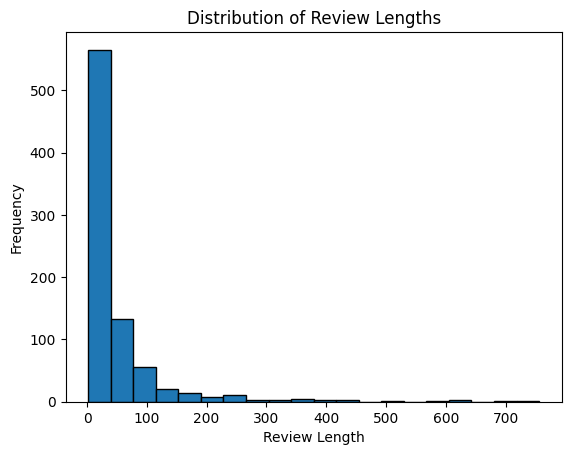

In [11]:
plt.hist(df["length"], bins=20, edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.show()

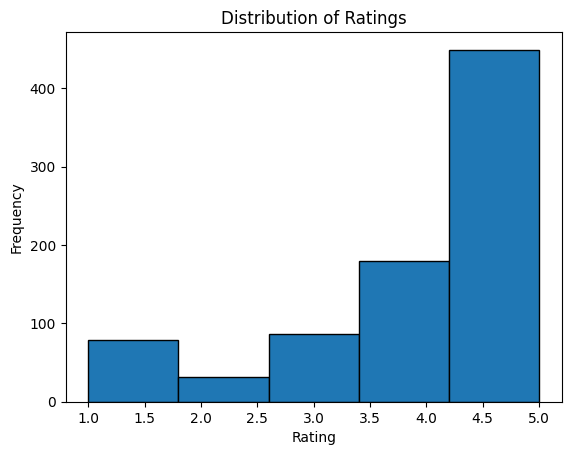

In [12]:
# df['rating'].value_counts()
plt.hist(df['rating'], bins=5, edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [13]:
df.groupby('rating')['length'].mean() #average length of reviews by rating

rating
1    58.506329
2    46.718750
3    57.114943
4    47.469274
5    44.340757
Name: length, dtype: float64

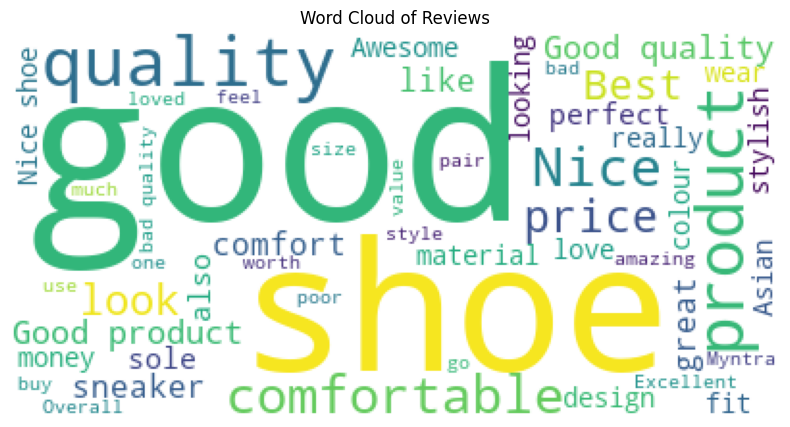

In [14]:
reviews = " ".join([review for review in df['review']])
wc = WordCloud(background_color='white', max_words=50, stopwords=STOPWORDS)

plt.figure(figsize=(10, 5))
plt.imshow(wc.generate(reviews))
plt.title("Word Cloud of Reviews")
plt.axis("off")
plt.show()

### Rating to Sentiment Mapping

In [15]:
# Maping ratings to categories
def map_rating(rating):
    if rating in [5, 4]:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    elif rating in [1, 2]:
        return 'Negative'

df['category'] = df['rating'].apply(map_rating)
df['category'].value_counts()

category
Positive    628
Negative    111
Neutral      87
Name: count, dtype: int64

### Encoding target variable-sentiment

In [16]:
# Encode labels in column 'category'.
label_encoder = preprocessing.LabelEncoder()  
df['sentiment']= label_encoder.fit_transform(df['category']) 
  
df['sentiment'].value_counts() 

sentiment
2    628
0    111
1     87
Name: count, dtype: int64

### Text Preprocessing

In [17]:
# Clean reviews
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    text = [stemmer.stem(word) for word in text if word not in STOPWORDS]
    return ' '.join(text)

df["cleaned_review"] = df["review"].apply(clean_text)


In [18]:
#TFIDF(Term Frequency Inverse Document Frequency) Convert cleaned text to numerical vectors
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
X = tfidf_vectorizer.fit_transform(df["cleaned_review"])
y = df["sentiment"]


In [19]:
X.shape

(826, 2360)

In [30]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (660, 2360)
Test shape: (166, 2360)


### With SMOTE we have high chance of overfitting for minority class so we can use class weights insted of this 

In [21]:
# Data Imbalance
# Method1: use class_weight='balanced' in the model

#method2: resampling technique
print(f'Original dataset shape : {Counter(y_train)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print(f'Resampled dataset shape {Counter(y_res)}')


Original dataset shape : Counter({2: 498, 0: 92, 1: 70})
Resampled dataset shape Counter({0: 498, 2: 498, 1: 498})


### Model Selection and Cross-Validation

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(random_state=42)
dt_cv = DecisionTreeClassifier(random_state=42)
knn_cv=KNeighborsClassifier()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN'}
cv_models=[logreg,dt_cv,knn_cv]



for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X_res, y_res, cv=10, scoring ='accuracy').mean()))


Logistic Regression Test Accuracy: 0.7530156599552573
Decision Tree Test Accuracy: 0.8038657718120806
KNN Test Accuracy: 0.6485279642058165


### Final Model Training

In [23]:
# Train Model
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVC": LinearSVC( max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

}

# Evaluate each on test data
for name, model in models.items():
    print(f"\n🧪 Training {name}...")
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    print(f"📊 {name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Negative", "Neutral", "Positive"]))


🧪 Training Logistic Regression...
📊 Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.32      0.41        19
     Neutral       0.07      0.35      0.12        17
    Positive       0.82      0.48      0.60       130

    accuracy                           0.45       166
   macro avg       0.50      0.38      0.38       166
weighted avg       0.72      0.45      0.53       166


🧪 Training SVC...
📊 SVC Classification Report:
              precision    recall  f1-score   support

    Negative       0.55      0.32      0.40        19
     Neutral       0.06      0.29      0.10        17
    Positive       0.81      0.45      0.58       130

    accuracy                           0.42       166
   macro avg       0.47      0.35      0.36       166
weighted avg       0.70      0.42      0.51       166


🧪 Training Random Forest...
📊 Random Forest Classification Report:
              precision    recall  f1-scor

### Save Final Model

In [24]:
import joblib

final_model = LogisticRegression(max_iter=1000, class_weight="balanced", multi_class="multinomial")
final_model.fit(X_res, y_res)

# Save TF-IDF and model
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(final_model, "logreg_sentiment_model.pkl")


c:\Users\gaura\OneDrive\Desktop\Test\scrape\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


['logreg_sentiment_model.pkl']

In [25]:
sample_review = df.iloc[153]['cleaned_review']
print("Review:", sample_review, "\nclass : ",df.iloc[153]['category'])


Review: good size scake littl differ 
class :  Positive


In [26]:
import joblib

# Load saved vectorizer and model
vectorizer = joblib.load("tfidf_vectorizer.pkl")
model = joblib.load("logreg_sentiment_model.pkl")


In [27]:
# Vectorize the review
X_sample = vectorizer.transform([sample_review])

# Predict class and probability
predicted_class = model.predict(X_sample)[0]
confidence = model.predict_proba(X_sample).max()

# Map label to text
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

print("Predicted Sentiment:", label_map[predicted_class])
print("Confidence Score:", round(confidence, 4))


Predicted Sentiment: Positive
Confidence Score: 0.4686
